<a href="https://colab.research.google.com/github/benschlup/csck507_team_a/blob/main/CSCK507_Team_A_WikiQA_Chatbot_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### **CSCK507 Natural Language Processing, March-May 2022: End-of-Module Assignment**
# **Generative Chatbot**
---
#### Team A
Muhammad Ali (Student ID 200050027)  
Benjamin Schlup (Student ID 200050007)  
Chinedu Abonyi (Student ID 200050028)  
Victor Armenta-Valdes (Student ID 222500001)

---
# **Solution 2: LSTM with Bahdanau Attention Layer**
---

Dataset being used: https://www.microsoft.com/en-us/download/details.aspx?id=52419  
Paper on dataset: https://aclanthology.org/D15-1237/  
Non-attention solution inspired by https://medium.com/swlh/how-to-design-seq2seq-chatbot-using-keras-framework-ae86d950e91d  
Bahdanau addition inspired by https://www.tensorflow.org/text/tutorials/nmt_with_attention  
Luong attention extension inspired by https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

Important note: 
The dataset includes incorrect answers, labelled accordingly. Learning from these can be switched on/off (see below).

In a real setting, it would be sensible to add a concept called "answer triggering" and exclude learning from incorrect answers. Answer triggering  first assesses a question to qualify if the model may deliver a sensible answer - otherwise let the person know that the bot does not know. Ref: https://ieeexplore.ieee.org/document/8079800

In this notebook, the default is set to learn from invalid answers. This leads to more data for learning and thus a greater awareness of how sentences are constructed. And sometimes in funny conversations like with a poorly hearing dialogue partner, who provides 'perfectly valid answers - but to a different question'.

---
## 1. Configuration and framework

In [1]:
# The dataset includes invalid answers (labelled 0) and some questions 
# even have no valid answer at all: Switches allow test runs excluding invalid
# answers.
# Note that the assignment says that answers must be provided by the chatbot: 
# there is no mention that answers must be correct!
train_with_invalid_answers = True
validate_with_invalid_answers = True
test_questions_without_valid_answers = True

# The dataset contains questions with multiple valid answers
train_with_duplicate_questions = True
validate_with_duplicate_questions = True
test_with_duplicate_questions = True

# Configure the tokenizer
vocab_size_limit = 6000 + 1 # set this to None if all tokens from training shall be included (add one to number of tokens)
vocab_include_val = False   # set this to True if tokens from validation set shall be included in vocabulary
vocab_include_test = False  # set this to True if tokens from test set shall be included in vocabulary
oov_token = 1               # set this to None if out-of-vocabulary tokens should be removed from sequences
remove_oov_sentences = True # set this to True if any sentences containing out-of-vocabulary tokens should be removed from training, validation, test dataset

# Limit sentence lengths // not yet implemented
max_question_tokens = None  # set this to None if no limit on question length
max_answer_tokens = None    # set this to None if no limit on answer length

# Model parameters
lstm_units = 150
embedding_units = 200
encoder_lstm_dropout = 0.2
encoder_lstm_recurrent_dropout = 0.2


# Training parameters
batch_size = 50
number_of_epochs = 100

In [2]:
# Imports
import codecs
import io
import os
import re
import urllib.request
import yaml
import random
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import Image

from tensorflow.keras.activations import softmax
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Embedding, LSTM, Dense, Concatenate, AdditiveAttention
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.keras import backend

import matplotlib.pyplot as plt

from keras_preprocessing.text import Tokenizer

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [3]:
# Make sure the GPU is visible to our runtime
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# Check what GPU we have in place
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 16 07:16:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
## 2. Data acquisition and loading

In [5]:
# Download data: If link does not work any longer, access file manually from here: https://www.microsoft.com/en-us/download/details.aspx?id=52419
urllib.request.urlretrieve("https://download.microsoft.com/download/E/5/F/E5FCFCEE-7005-4814-853D-DAA7C66507E0/WikiQACorpus.zip", "WikiQACorpus.zip")

('WikiQACorpus.zip', <http.client.HTTPMessage at 0x7f207ffecbd0>)

In [6]:
# Extract files
with zipfile.ZipFile('WikiQACorpus.zip', 'r') as zipfile:
   zipfile.extractall()

In [7]:
# Import questions and answers: training, validation and test datasets
train_df = pd.read_csv( f'./WikiQACorpus/WikiQA-train.tsv', sep='\t', encoding='ISO-8859-1')
val_df = pd.read_csv( f'./WikiQACorpus/WikiQA-dev.tsv', sep='\t', encoding='ISO-8859-1')
test_df = pd.read_csv( f'./WikiQACorpus/WikiQA-test.tsv', sep='\t', encoding='ISO-8859-1')       

---
## 3. Dataset preparation (pre-processing, transformation)
Note that no cleansing as such is required, as prior analysis has shown.

In [8]:
# Quality checks and exploratory data analysis removed: dataset has proven clean
# Print gross volumes:
print(f'Gross training dataset size: {len(train_df)}')
print(f'Gross validation dataset size: {len(val_df)}')
print(f'Gross test dataset size: {len(test_df)}')

Gross training dataset size: 20347
Gross validation dataset size: 2733
Gross test dataset size: 6116


In [9]:
# Derive normalized questions and answers and count number of tokens
for df in [train_df, val_df, test_df]:
    df.loc[:,'norm_question'] = [ re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", q).lower().strip() for q in df['Question'] ]
    df.loc[:,'norm_answer'] = [ '_START_ '+re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", s).lower().strip()+' _STOP_' for s in df['Sentence']]
    df['question_tokens'] = [ len(x.split()) for x in df['norm_question'] ]
    df['answer_tokens'] = [ len(x.split()) for x in df['norm_answer'] ]

In [10]:
# Drop sentences which are too long
for df in [train_df, val_df, test_df]:
    if max_question_tokens is not None:
        df.drop(df[df['question_tokens']>max_question_tokens].index, inplace=True)
    if max_answer_tokens is not None:
        df.drop(df[df['answer_tokens']>max_answer_tokens+2].index, inplace=True)    

In [11]:
# Remove q/a pairs depending on configuration of the notebook
if not train_with_invalid_answers:
    train_df = train_df[train_df['Label'] == 1]
if not validate_with_invalid_answers:
    val_df = val_df[val_df['Label'] == 1]
if not test_questions_without_valid_answers:
    test_df = test_df[test_df['Label'] == 1]

In [12]:
# Remove duplicate questions in case configured to do so
if not train_with_duplicate_questions:
    train_df.drop_duplicates(subset=['Question'], inplace=True)
if not validate_with_duplicate_questions:
    validate_df.drop_duplicates(subset=['Question'], inplace=True)
if not test_with_duplicate_questions:
    test_df.drop_duplicates(subset=['Question'], inplace=True)

In [13]:
# Data preparation:
# Tokenization:
# Reconsider adding digits to filter later, as encoding of numbers may create excessive vocabulary
# Also check reference on handling numbers in NLP: https://arxiv.org/abs/2103.13136
# Note that I do not yet train the tokenizer on validation and test datasets - should be challenged. 
# my be added to Tokenizer filters=target_regex = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\''

if remove_oov_sentences:
    oov_token = None
tokenizer = Tokenizer(num_words=vocab_size_limit, oov_token=oov_token)

tokenizer.fit_on_texts(train_df['norm_question'] + train_df['norm_answer'])
if vocab_include_val:
    tokenizer.fit_on_texts(val_df['norm_question'] + val_df['norm_answer'])
if vocab_include_test:
    tokenizer.fit_on_texts(test_df['norm_question'] + test_df['norm_answer'])

vocab_size = len(tokenizer.word_index) + 1
if vocab_size_limit is not None:
    vocab_size = min([vocab_size, vocab_size_limit])
print(f'Vocabulary size based on training dataset: {vocab_size}')

for df in [train_df, val_df, test_df]:
    # Tokenize
    df['tokenized_question'] = tokenizer.texts_to_sequences(df['norm_question'])
    df['tokenized_answer'] = tokenizer.texts_to_sequences(df['norm_answer'])

    # Optionally remove sentences with out-of-vocabulary tokens
    if remove_oov_sentences:
        df.drop(df[df['question_tokens']!=df['tokenized_question'].str.len()].index, inplace=True)
        df.drop(df[df['answer_tokens']!=df['tokenized_answer'].str.len()].index, inplace=True)

Vocabulary size based on training dataset: 6001


In [14]:
# Print net volumes
print(f'Net training dataset size: {len(train_df)}')
print(f'Net validation dataset size: {len(val_df)}')
print(f'Net test dataset size: {len(test_df)}')

Net training dataset size: 2181
Net validation dataset size: 108
Net test dataset size: 252


In [15]:
# Transform data for training and validation by aligning lengths (i.e. padding)
maxlen_questions = max(len(t) for t in train_df['tokenized_question'].to_list())
maxlen_answers = max(len(t) for t in train_df['tokenized_answer'].to_list())

train_encoder_input_data = pad_sequences(train_df['tokenized_question'], maxlen=maxlen_questions, padding='post')
val_encoder_input_data = pad_sequences(val_df['tokenized_question'], maxlen=maxlen_questions, padding='post')
print(f'Encoder input data shape: {train_encoder_input_data.shape}')

train_decoder_input_data = pad_sequences(train_df['tokenized_answer'], maxlen=maxlen_answers, padding='post')
val_decoder_input_data = pad_sequences(val_df['tokenized_answer'], maxlen=maxlen_answers, padding='post')
print(f'Decoder input data shape: {train_decoder_input_data.shape}')

tokenized_answers = [ ta[1:] for ta in train_df['tokenized_answer'] ]
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
train_decoder_output_data = to_categorical(padded_answers, vocab_size)
tokenized_answers = [ ta[1:] for ta in val_df['tokenized_answer'] ]
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
val_decoder_output_data = to_categorical(padded_answers, vocab_size)
print(f'Decoder output data shape: {train_decoder_output_data.shape}')

Encoder input data shape: (2181, 21)
Decoder input data shape: (2181, 52)
Decoder output data shape: (2181, 52, 6001)


---
## 4. Modelling and training

In [16]:
# Build model

# Input layer for encoder
enc_inputs = Input(shape=(None,), name='Encoder_Input')

# Embedding layer for encoder
enc_embedding = Embedding(vocab_size, embedding_units, mask_zero=True, 
                          name='Encoder_Embedding')(enc_inputs)

# LSTM layer for encoder
stack_h, state_h, state_c = LSTM(lstm_units, 
                                 return_state=True, 
                                 return_sequences=True,
                                 dropout=encoder_lstm_dropout,
                                 recurrent_dropout=encoder_lstm_recurrent_dropout,
                                 name='Encoder_LSTM')(enc_embedding)

# Combine states from encoder LSTM layer
enc_states = [state_h, state_c]

# Input layer for decoder
dec_inputs = Input(shape=(None,), name='Decoder_Input')

# Embedding layer for decoder
dec_embedding = Embedding(vocab_size, embedding_units, mask_zero=True, name='Decoder_Embedding')(dec_inputs)

# LSTM layer for decoder
dec_lstm = LSTM(lstm_units, 
                return_state=True, 
                return_sequences=True, 
                name='Decoder_LSTM')
dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)

# Bahdanau-style attention layer
attn_layer = AdditiveAttention(name='Bahdanau')
#attn_op, attn_state = attn_layer([stack_h, dec_outputs])
attn_op = attn_layer([dec_outputs, stack_h])

decoder_concat_input = Concatenate(axis=-1, name='Combine')([dec_outputs, attn_op])

# Dense layer for decoder
dec_dense = Dense(vocab_size, activation=softmax, name='Decoder_Dense')
output = dec_dense(decoder_concat_input)

# Compile the model
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarised printout
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Decoder_Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder_Embedding (Embedding)  (None, None, 200)    1200200     ['Encoder_Input[0][0]']          
                                                                                                  
 Decoder_Embedding (Embedding)  (None, None, 200)    1200200     ['Decoder_Input[0][0]']          
                                                                                              

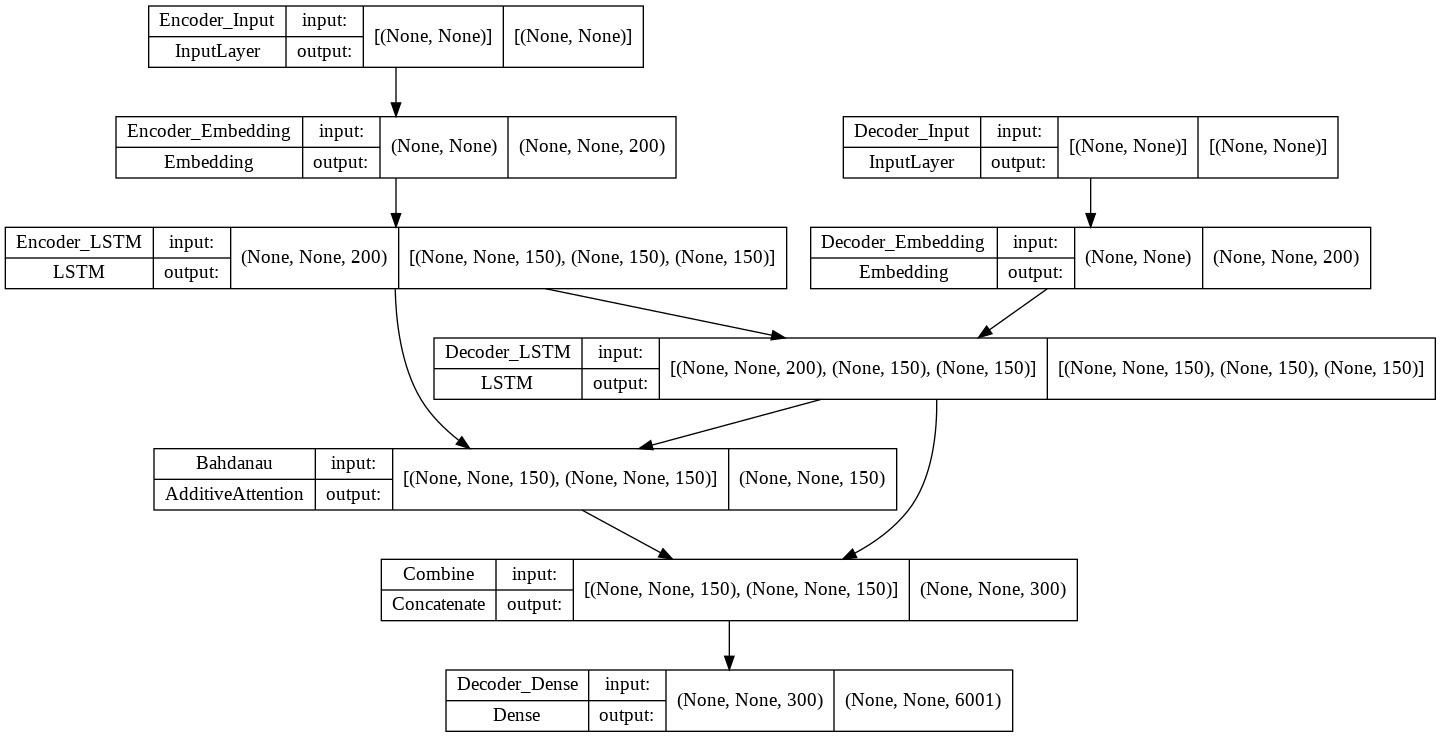

In [17]:
# Visualise the training model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='training_model.png')
Image('training_model.png')

In [18]:
# Model training

history = model.fit([train_encoder_input_data, train_decoder_input_data], train_decoder_output_data,
                     validation_data=([val_encoder_input_data, val_decoder_input_data], val_decoder_output_data),
                     batch_size=batch_size, epochs=number_of_epochs)

Epoch 1/100
44/44 [==============================] - 14s 156ms/step - loss: 2.2176 - accuracy: 0.0943 - val_loss: 2.0291 - val_accuracy: 0.1059
Epoch 2/100
44/44 [==============================] - 5s 119ms/step - loss: 1.9986 - accuracy: 0.1259 - val_loss: 1.9672 - val_accuracy: 0.1615
Epoch 3/100
44/44 [==============================] - 5s 122ms/step - loss: 1.9291 - accuracy: 0.1677 - val_loss: 1.9289 - val_accuracy: 0.1896
Epoch 4/100
44/44 [==============================] - 5s 122ms/step - loss: 1.8673 - accuracy: 0.1906 - val_loss: 1.8874 - val_accuracy: 0.1923
Epoch 5/100
44/44 [==============================] - 5s 120ms/step - loss: 1.8146 - accuracy: 0.2019 - val_loss: 1.8600 - val_accuracy: 0.2026
Epoch 6/100
44/44 [==============================] - 5s 120ms/step - loss: 1.7693 - accuracy: 0.2082 - val_loss: 1.8423 - val_accuracy: 0.2048
Epoch 7/100
44/44 [==============================] - 5s 119ms/step - loss: 1.7285 - accuracy: 0.2156 - val_loss: 1.8245 - val_accuracy: 0.213

In [19]:
# Optionally save model to file:
#model.save('/content/drive/MyDrive/CSCK507_Team_A/qa_model2.h5')
#model.save_weights('/content/drive/MyDrive/CSCK507_Team_A/qa_model2_weights.h5')

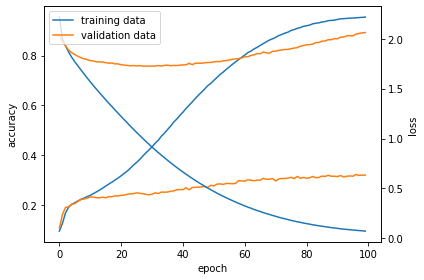

In [20]:
# Visualise training progress
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
ax2.tick_params(axis='y')

fig.tight_layout()
plt.legend(['training data', 'validation data'], loc='upper left')
plt.show()

---
## 5. Validation

In [21]:
# Optionally load model weights from file if already trained:
# WARNING: Any notebook parameters and the learned vocabulary are not 
# saved/loaded - i.e. this only makes sense when all other cells of the notebook
# are run except for the model.fit
#model.load('/content/drive/MyDrive/CSCK507_Team_A/qa_model2.h5')
#model.load_weights('/content/drive/MyDrive/CSCK507_Team_A/qa_model2_weights.h5')

In [22]:
# Prepare models for inferencing (separate encoder, decoder)

# Build encoder model for inferencing
enc_model = Model(inputs=enc_inputs, outputs=[stack_h, enc_states], name='Inference_Encoder')
enc_model.summary()

# Build decoder model for inferencing
dec_state_input_h = Input(shape=(lstm_units,))
dec_state_input_c = Input(shape=(lstm_units,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]
dec_outputs, state_h, state_c = dec_lstm(dec_embedding, initial_state=dec_states_inputs)

dec_states = [state_h, state_c]

dec_model = Model(inputs=[dec_inputs, dec_states_inputs], outputs=[dec_outputs] + dec_states, name='Inference_Decoder')

dec_model.summary()

Model: "Inference_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, None)]            0         
                                                                 
 Encoder_Embedding (Embeddin  (None, None, 200)        1200200   
 g)                                                              
                                                                 
 Encoder_LSTM (LSTM)         [(None, None, 150),       210600    
                              (None, 150),                       
                              (None, 150)]                       
                                                                 
Total params: 1,410,800
Trainable params: 1,410,800
Non-trainable params: 0
_________________________________________________________________
Model: "Inference_Decoder"
______________________________________________________________________________

In [23]:
# Prepare question for inferencing

def tokenize(question):
    words = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", question).lower().split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
        else:
            print(f'Warning: out-of-vocabulary token \'{current_word}\'')
            if oov_token is not None:
                tokens_list.append(oov_token)

    return pad_sequences([tokens_list],
                         maxlen=maxlen_questions,
                         padding='post')

In [24]:
 # Predict answer and compare to ground truth options

 def predict_answer(question, qa_df=None):
    enc_op, states_values = enc_model.predict(tokenize(question))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']

    decoded_answer = ''
    while True:
        dec_outputs, state_h, state_c = dec_model.predict([empty_target_seq] + states_values)

        attn_op = attn_layer([dec_outputs, enc_op])
        decoder_concat_input = Concatenate(axis=-1)([dec_outputs, attn_op])
        dec_outputs = dec_dense(decoder_concat_input)

        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'stop':
                    decoded_answer += ' {}'.format(word)
                sampled_word = word

        if sampled_word == 'stop' or len(decoded_answer.split()) > maxlen_answers:
            break

        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [state_h, state_c]

    # Skip START token
    decoded_answer = decoded_answer[1:]

    print(f'Original question: {question}')
    print(f'Predicated answer: {decoded_answer}\n')

    if qa_df is not None:
        # The following should contain all acceptable answers
        reference_answers = qa_df.loc[qa_df['Question']==question, 'norm_answer'].to_list()
        reference_answers = [ re.sub(' +', ' ', answer[8:-7]) for answer in reference_answers]
        print(f'{reference_answers}')

        # Calculate BLEU score: Note that little differences may result from e.g.
        # spaces that were added to norm_answer when replacing punctuation earlier
        bleu_score = sentence_bleu(reference_answers, decoded_answer, smoothing_function=SmoothingFunction().method0)
        
        print(f'BLEU score: {bleu_score}\n')

    else:
        bleu_score = None

    return bleu_score

In [25]:
# Validate how the model predicts:
# Get 20 random numbers to choose random sentences and calculate BLEU score
# per predicted answer but also on average

def validate_predictions(qa_df):
    bleu_total = 0
    number_of_samples = min(20, len(qa_df.index))

    for sample_question in qa_df['Question'].sample(number_of_samples, random_state=42):
        bleu_total += predict_answer(sample_question, qa_df)

    print(f'BLEU average for answers on trained questions (n={number_of_samples}) = {bleu_total/number_of_samples}')

In [26]:
# Validate how the model predicts from actually trained questions

print('Validating model against sample set from training questions\n')
validate_predictions(train_df)

Validating model against sample set from training questions

Original question: what happened to stevie ray vaughan
Predicated answer: in june 1989 in step was released and earned them a grammy award for best contemporary blues performance

['stephen stevie ray vaughan october 3 1954 â\x80\x93 august 27 1990 was an american guitarist singersongwriter and record producer', 'often referred to by his initials srv vaughan is best known as a founding member and leader of double trouble', 'in june 1989 in step was released and earned them a grammy award for best contemporary blues performance', 'stevie ray vaughan is widely considered to be one of the greatest musicians to come from the state of texas']
BLEU score: 1.0

Original question: What did the Supreme Court determine in Dred Scott v. Sandford?
Predicated answer: to which the court noted

['dred scott v sandford also known as the dred scott decision was a landmark decision by the us supreme court', 'the second ruling was that the fede

In [27]:
# Validate how the model predicts from test questions (i.e. unseen)

print('Validating model against sample set from test questions:')
print('''
  ! NOTE THAT ASKING FOR ANSWERS ON UNSEEN QUESTIONS IS BARELY HELPFUL WITH
  ! LITTLE DATASETS AND LITTLE VARIANCE ON BOTH Q/A SIDES:
  !ADDING "ANSWER TRIGGERING" CONCEPT MAY BE PRUDENT
  ''')
validate_predictions(test_df)

Validating model against sample set from test questions:

  ! NOTE THAT ASKING FOR ANSWERS ON UNSEEN QUESTIONS IS BARELY HELPFUL WITH
  ! LITTLE DATASETS AND LITTLE VARIANCE ON BOTH Q/A SIDES:
  !ADDING "ANSWER TRIGGERING" CONCEPT MAY BE PRUDENT
  
Original question: what year was President kennedy president?
Predicated answer: in 1968 he ran again for the presidency and was elected

['thereafter he served in the us senate from 1953 until 1960', 'kennedy defeated vice president and republican candidate richard nixon in the 1960 us presidential election', 'kennedy was assassinated on november 22 1963 in dallas texas', "since the 1960s information concerning kennedy's private life has come to light", 'kennedy ranks highly in public opinion ratings of us presidents']
BLEU score: 0.6239518743862836

Original question: what countries did immigrants come from during the immigration
Predicated answer: in 1924 cities may also become native american americans which were granted any in any other

### Targeted validation
Performed with three types of questions:
* Question from actual training set
* Question from test set (i.e. unseen) -> only to verify if 'a' answer is provided
* Reworded questions from actual training set: demonstrate robustness

In [28]:
print('TEST CASE 1: Accurate question from actual training dataset')
predict_answer('How are glacier caves formed?')

print('TEST CASE 2: Varying the question from the actual training dataset')
predict_answer('How are glacial caves formed?')

print('TEST CASE 3: Accurate question from actual training dataset')
predict_answer('When was Apple Computer founded?')

print('TEST CASE 4: Varying the question from the actual training dataset')
predict_answer('When was Apple founded?')

print('TEST CASE 5: Varying the question from the actual training dataset')
predict_answer('When was Apple Computer established?')

print('TEST CASE 6: Unseen question from test set')
predict_answer('How many players on a side for a football game?')

print('TEST CASE 7: Varying the unseen question from test set')
predict_answer('How many players per team in a football game?')

print('TEST CASE 8: Long question from training dataset')
predict_answer('What group took home the award for best rock album at the Australian Recording Industry Association (ARIA) Music Awards?')

print('TEST CASE 9: Varying the long question from the training dataset')
predict_answer('What group took got the award for best album at the ARIA Music Awards?')

TEST CASE 1: Accurate question from actual training dataset
Original question: How are glacier caves formed?
Predicated answer: a glacier cave is a cave formed within the ice of a glacier

TEST CASE 2: Varying the question from the actual training dataset
Original question: How are glacial caves formed?
Predicated answer: a glacier cave is a cave formed within the ice of a glacier

TEST CASE 3: Accurate question from actual training dataset
Original question: When was Apple Computer founded?
Predicated answer: the company was founded on april 1 1976 and incorporated as apple computer inc on january 3 1977

TEST CASE 4: Varying the question from the actual training dataset
Original question: When was Apple founded?
Predicated answer: the company was founded on april 1 1976 and incorporated as apple computer inc on january 3 1977

TEST CASE 5: Varying the question from the actual training dataset
Original question: When was Apple Computer established?
Predicated answer: the company was f

### Manual validation

In [29]:
while True:
    test_case = input('Enter test case description, or enter \'end\' to stop: ')
    if test_case == 'end':
        break
    question = input('Ask me something: ')

    predict_answer(question)
    print()

Enter test case description, or enter 'end' to stop: end


---
# END OF NOTEBOOK
---